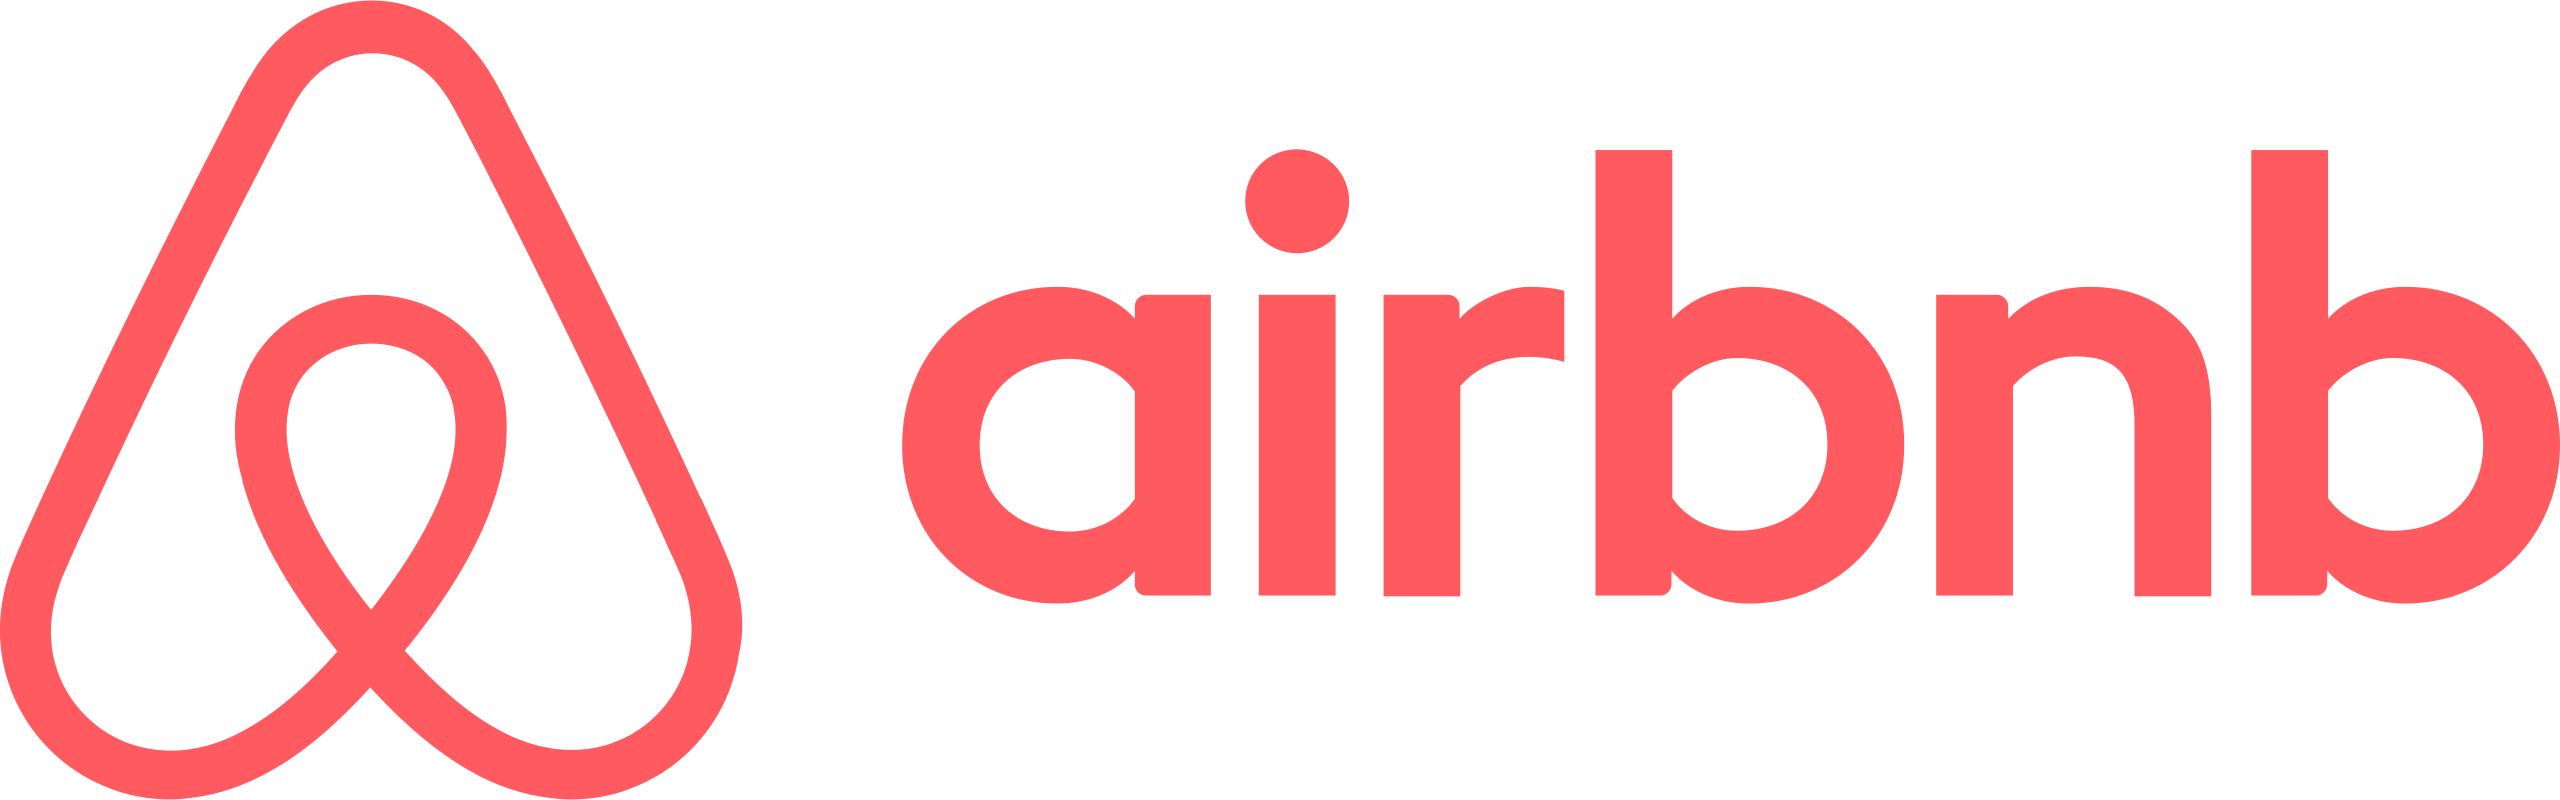

# Airbnb Host Score Prediction: Modeling, Evaluation and Conclusion

Notebook: 4 of 4

## Recap

This far in the project, we have done the following:
- Cleaned the data 
- Explored the data using visuals such as maps and charts
- Performed basic feature engineering 
- Encoded the data using a vareity of methods such as Tfidf Vectorization, Multi-Label Binarization, and One Hot Encoding


--------

## Purpose

The purpose of this notebook is to test out a few different model types, tune their hyperparameters, evaluate those models, and select a final model to proceed with

## Please Note: You will need the specified environment to run this notebook successfully. Please download the respective `modeling_env.yml` file 

Instructions to set up an environment from a `.yml` file can be found here: https://conda.io/projects/conda/en/latest/user-guide/tasks/manage-environments.html#creating-an-environment-from-an-environment-yml-file

Let's import the relevant libraries:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

Now we can read in our data, remember our train test split has already been completed in the Encoding notebook.

In [2]:
X_train = pd.read_csv('Modeling_Datasets/X_train_processed.csv')
X_val = pd.read_csv('Modeling_Datasets/X_val_processed.csv')
X_test = pd.read_csv('Modeling_Datasets/X_test_processed.csv')

In [3]:
y_train = pd.read_csv('Modeling_Datasets/y_train_binary.csv')
y_val = pd.read_csv('Modeling_Datasets/y_val_binary.csv')
y_test = pd.read_csv('Modeling_Datasets/y_test_binary.csv')

Let's check the shapes of each dataset:

In [4]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)


(17550, 464)
(7522, 464)
(10746, 464)


In [5]:
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(17550, 1)
(7522, 1)
(10746, 1)


Our target datasets are not in the correct format for a lot of the models that we will try. Let's convert them using the `np.ravel()` method from the `numpy` library.

In [6]:
y_train = np.ravel(y_train)
y_val = np.ravel(y_val)
y_test = np.ravel(y_test)

Let's double check to make sure that has worked.

In [7]:
print(f'New y_train shape: {y_train.shape}')
print(f'New y_val shape: {y_val.shape}')
print(f'New y_test shape: {y_test.shape}')

New y_train shape: (17550,)
New y_val shape: (7522,)
New y_test shape: (10746,)


Great, let's run our first model. We will start with a Decision Tree Classifier.

## Decision Tree Model

In [8]:
from sklearn.tree import DecisionTreeClassifier

The main hyperparameter of a decision tree model is the `max_depth`. Here we will be looping over various depth values and plotting the accuracy scores of each.

In [9]:
train_accs = []
val_accs = []

for depth in range(1, 15): # Iterating over depths from 1 to 15
    
    #instantiate
    dt_model = DecisionTreeClassifier(max_depth = depth) # Instantiate the model
    
    # fit
    dt_model.fit(X_train, y_train)
    
    # score on train and validation sets
    train_score = dt_model.score(X_train, y_train)
    val_score = dt_model.score(X_val, y_val)
    
    #Append to lists
    train_accs.append(train_score)
    val_accs.append(val_score)

Now we can plot the results, and decide on a `max_depth` for our testing set:

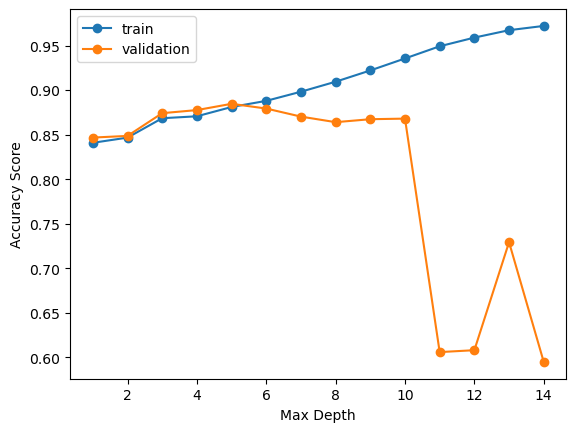

In [10]:
# Plotting the results
plt.figure()
plt.plot(range(1, 15), train_accs, label='train', marker='o')
plt.plot(range(1, 15), val_accs, label='validation', marker='o')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy Score')
plt.legend()
plt.show()

It looks like our best validation score that is less than the training score is around a `max_depth` of 6. We will use that parameter for our tuned model:

In [11]:
final_dt_model = DecisionTreeClassifier(max_depth = 6) # Instantiate the model

# Fit the model
final_dt_model.fit(X_train, y_train)

# Score the model
training_score = final_dt_model.score(X_train, y_train)
testing_score = final_dt_model.score(X_test, y_test)

# Print the scores
print(f'Training Score: {round(training_score, 3)}')
print(f'Testing Score: {round(testing_score, 3)}')

Training Score: 0.888
Testing Score: 0.876


That did pretty well! The model was able to predict a good versus a bad review with almost 88% accuracy on the testing set, and does not seem to be overfitting. Let's invesigate these results a bit further with a confusion matrix, precision score, recall score and F1 score:

In [12]:
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, precision_score, recall_score, f1_score

To calculate precision, recall and the F1 score, we will need to generate predictions from our model:

In [13]:
y_pred = final_dt_model.predict(X_test)


We can calculate precision score by simply calling the method. It is important to note the order of arguments: test set first, followed by predictions. This applies to precision, recall and the F1 Score

In [14]:
precision_score(y_test, y_pred)

0.8885093592020767

In [15]:
recall_score(y_test, y_pred)

0.9263532763532764

In [16]:
f1_score(y_test, y_pred)

0.9070367529116395

Let's create a DataFrame to store all of our model evaluation metrics:

In [17]:
data = [['DT_w_predictors', 'First DT Model', precision_score(y_test, y_pred),
       recall_score(y_test, y_pred), f1_score(y_test, y_pred)]]
model_comparison_df = pd.DataFrame(data, columns=['Model Instance', 'description', 'precision', 'recall', 'F1'])

In [18]:
model_comparison_df

,Model Instance,description,precision,recall,F1
0,DT_w_predictors,First DT Model,0.888509,0.926353,0.907037


Now we have a readable format in which we can compare our models. Let's also look at the confusion matrix for this model:

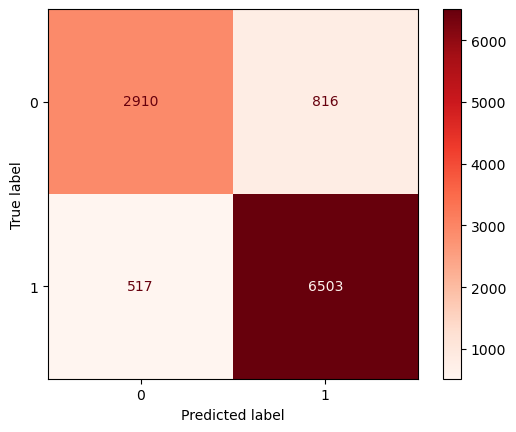

In [19]:
plot_confusion_matrix(final_dt_model, X_test, y_test, cmap='Reds');

That did pretty good! Some important insights are below:
- The model had 515 false negatives
- The model had 819 false positives
- This model was generally able to predict whether a review was good or bad

Let's see how this model was making it's decisions. We can do that by using the `plot_tree` method from sklearn.

In [20]:
from sklearn.tree import plot_tree

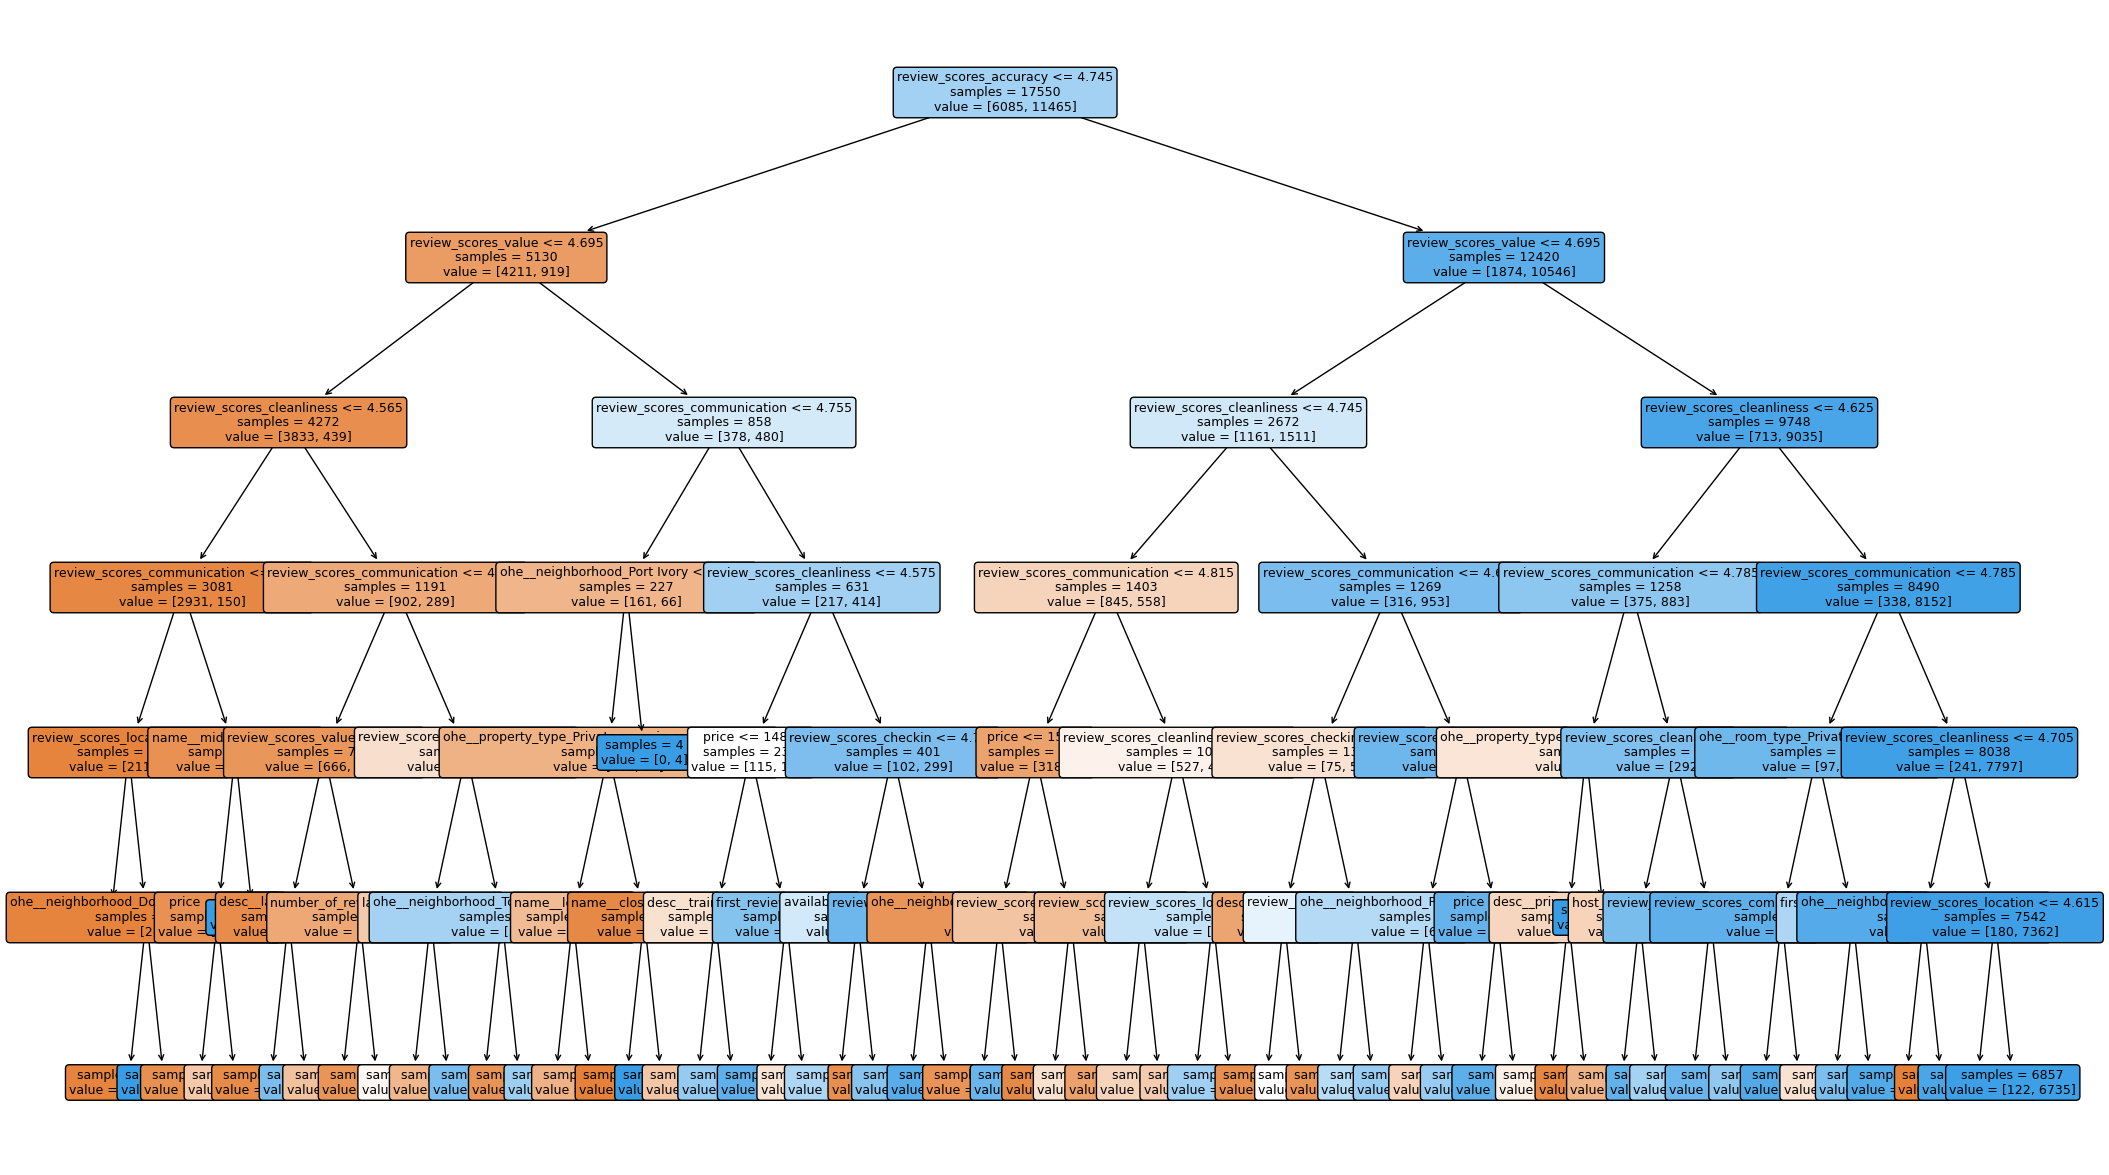

In [21]:
fig, ax = plt.subplots(figsize=(25, 15))

plot_tree(final_dt_model,
         feature_names=X_test.columns,
         rounded=True,
         impurity=False,
         filled=True,
         ax=ax,
         fontsize=9);

From the above tree, the model is classifying a host's review score based on their other review scores! This is not good if we are trying to predict a new host's review score. We will remove these multicollinear features below:

In [22]:
cols_to_remove = ['review_scores_accuracy', 'review_scores_cleanliness',
 'review_scores_checkin', 'review_scores_communication',
 'review_scores_location', 'review_scores_value']

dataframes = [X_train, X_val, X_test]

for df in dataframes: # Looping over our values
    df.drop(columns=cols_to_remove, inplace=True)
    
# Checking to make sure that it has worked
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(17550, 458)
(7522, 458)
(10746, 458)


Let's try the same Decision Tree Model again:

In [23]:
train_accs = []
val_accs = []

for depth in range(1, 15):
    
    #instantiate
    dt_model1 = DecisionTreeClassifier(max_depth = depth)
    
    # fit
    dt_model1.fit(X_train, y_train)
    
    # score on train and validation sets
    train_score = dt_model1.score(X_train, y_train)
    val_score = dt_model1.score(X_val, y_val)
    
    #Append to lists
    train_accs.append(train_score)
    val_accs.append(val_score)

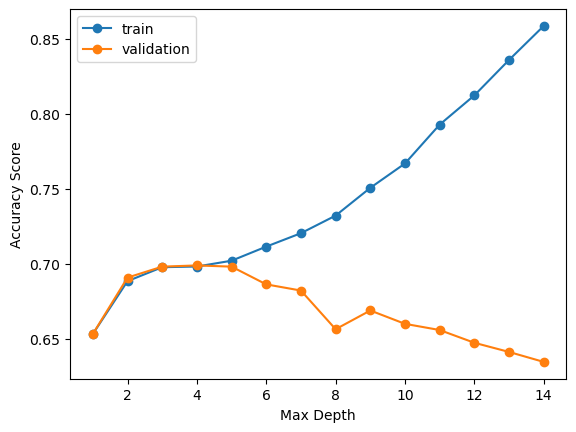

In [24]:
# Plotting the results
plt.figure()
plt.plot(range(1, 15), train_accs, label='train', marker='o')
plt.plot(range(1, 15), val_accs, label='validation', marker='o')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy Score')
plt.legend()
plt.show()

Those scores are much different! It looks like our model begins overfitting at a `max_depth` of around 6. Our best validation score seems to be at a `max_depth` of around 3. We will run the model on the testing set using that value.

In [25]:
final_dt_model = DecisionTreeClassifier(max_depth = 3) # Instantiate the model

# Fit the model
final_dt_model.fit(X_train, y_train)

# Score the model
training_score = final_dt_model.score(X_train, y_train)
testing_score = final_dt_model.score(X_test, y_test)

# Print the results
print(f'Training Score: {round(training_score, 5)}')
print(f'Testing Score: {round(testing_score, 5)}')

Training Score: 0.69783
Testing Score: 0.69337


That accuracy score does not seem too bad, but with imbalanced data we have to remember that if we were to predict only the positive class, we would have an accuracy of ~65%

In [26]:
pd.Series(y_test).value_counts()[1] / y_test.shape[0]

0.6532663316582915

Let's generate our predictions so we can add this model to our dataframe.

In [27]:
y_pred = final_dt_model.predict(X_test)


In [28]:
data = ['DT_w_tuning', 'Second DT Model', precision_score(y_test, y_pred),
       recall_score(y_test, y_pred), f1_score(y_test, y_pred)]
data

['DT_w_tuning',
 'Second DT Model',
 0.7108570134722065,
 0.8944444444444445,
 0.7921529048129692]

In [29]:
model_comparison_df.loc[len(model_comparison_df)] = data
model_comparison_df

,Model Instance,description,precision,recall,F1
0,DT_w_predictors,First DT Model,0.888509,0.926353,0.907037
1,DT_w_tuning,Second DT Model,0.710857,0.894444,0.792153


Below is a function which does the steps of the above cells:

In [30]:
def add_results(model, df, X_test, y_test, model_name, model_desc):
    y_pred = model.predict(X_test)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    data = [model_name, model_desc, precision, recall, f1]
    df.loc[len(df)] = data
    return df

Let's see how this decision tree is making it's decisions:

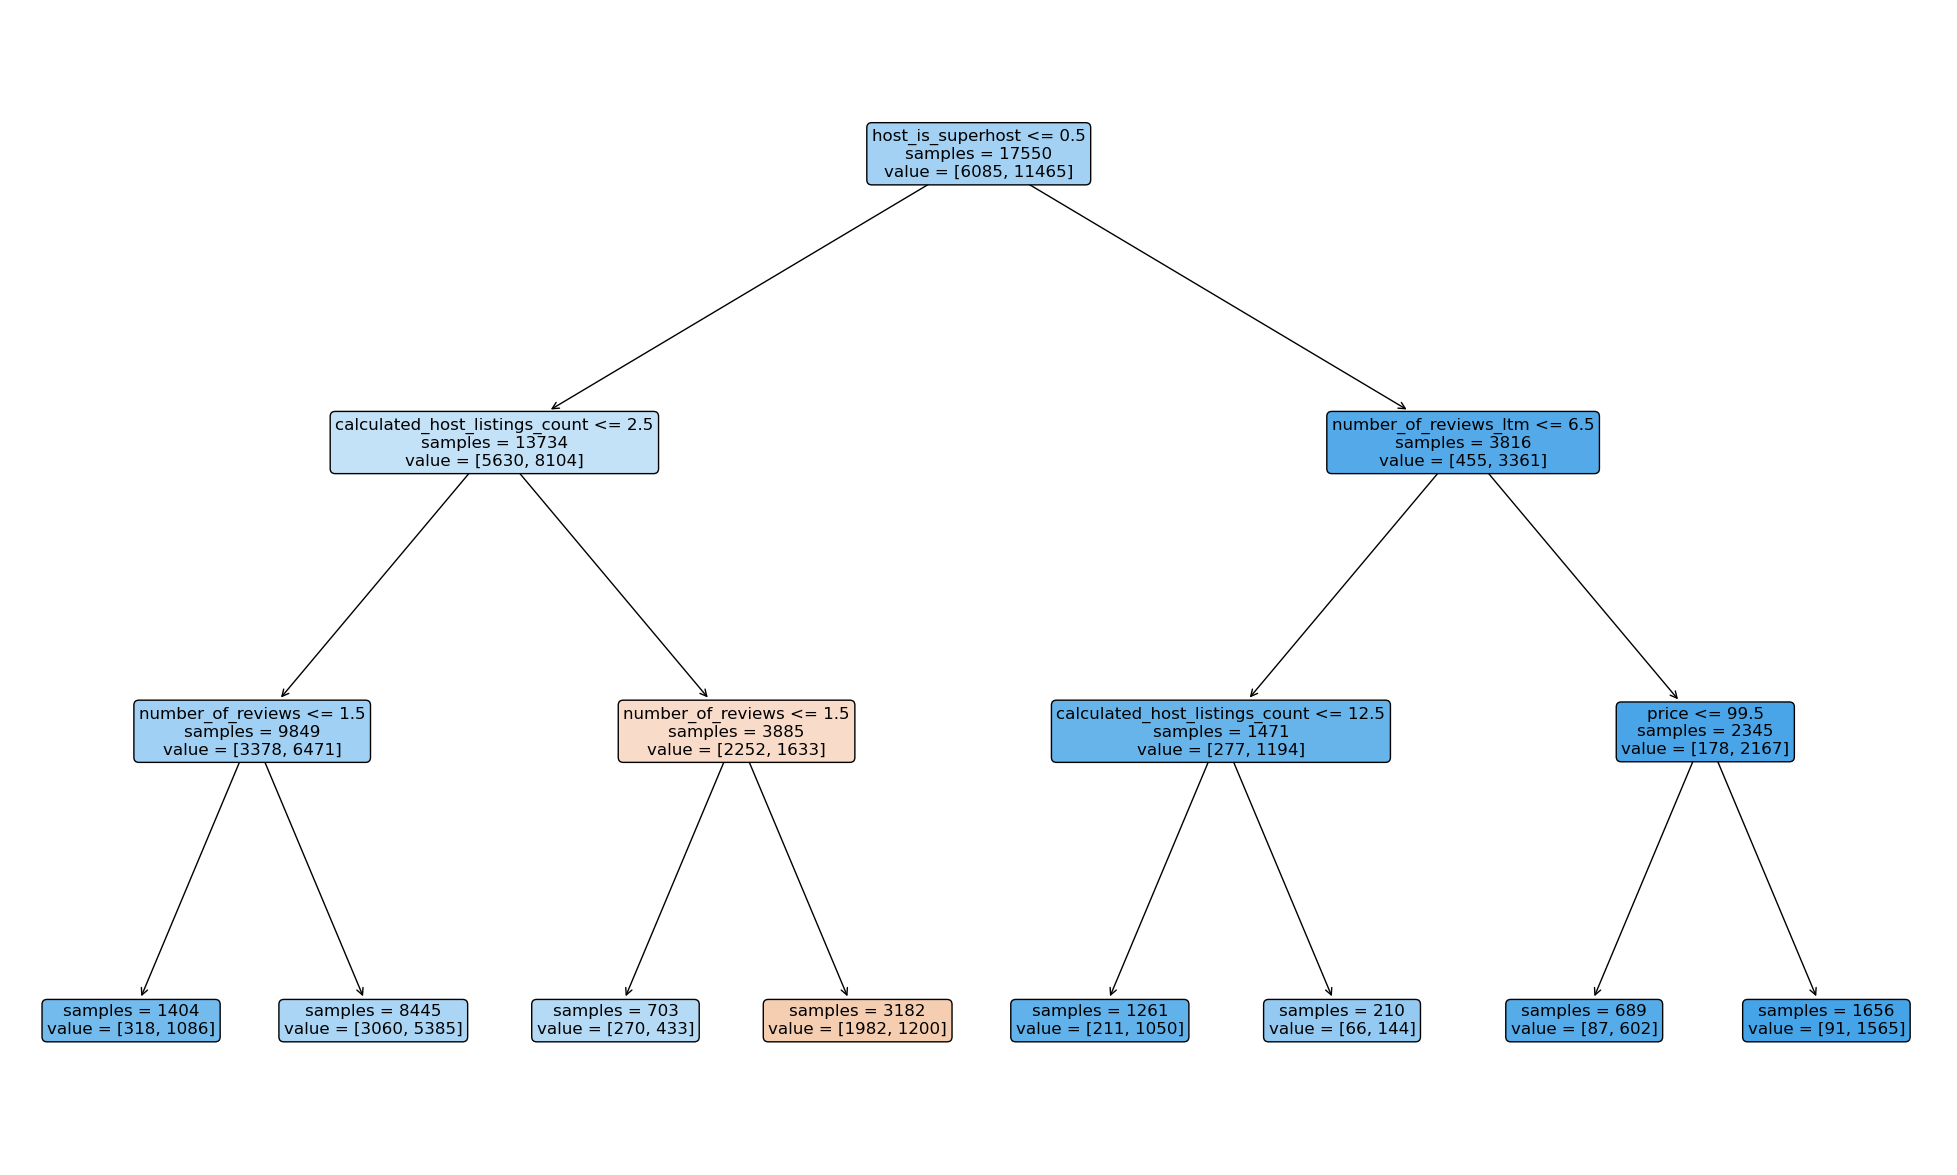

In [31]:
fig, ax = plt.subplots(figsize=(25, 15))

plot_tree(final_dt_model,
         feature_names=X_test.columns,
         rounded=True,
         impurity=False,
         filled=True,
         ax=ax,
         fontsize=12);

That is interesting to see how the model is making decisions. The most important variable was `host_is_superhost` followed by `calculated_host_listings_count` and `number_of_reviews_ltm`. Let's plot the confusion matrix.

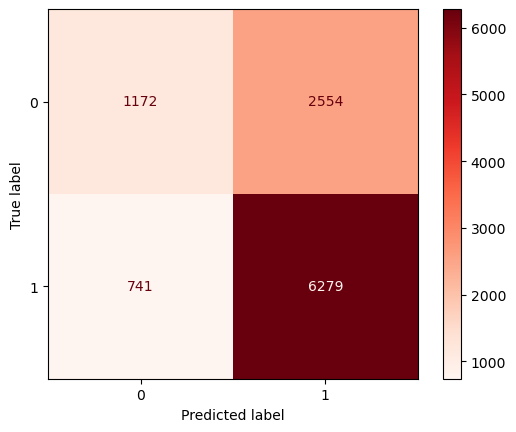

In [32]:
plot_confusion_matrix(final_dt_model, X_test, y_test, cmap='Reds');

Compared to our first decision tree model, this model had a much higher false positive rate, with 2,554 false positives. 

-------

That will conclude our testing of the Decision Tree model, let's now try a random forest model.

## Random Forest Model

In [33]:
from sklearn.ensemble import RandomForestClassifier

In [34]:
from sklearn.preprocessing import StandardScaler

In [35]:
ss = StandardScaler()
ss.fit(X_train)
X_train_ss = ss.transform(X_train)
X_val_ss = ss.transform(X_val)
X_test_ss = ss.transform(X_test)

The random forest model has two primary hyperparameters that we can tune:
- `n_estimators`
- `max_depth`

We will first tune the number of estimators and then tune the max depth

In [36]:
n_estimators_range = range(1, 51)
results = pd.DataFrame()
for estimator in n_estimators_range:
    
    # Instantiate the model
    rf = RandomForestClassifier(n_estimators = estimator, random_state=10)
    
    #Fit the model
    rf.fit(X_train_ss, y_train)
    
    # Score the model and append to a list
    train_score = rf.score(X_train_ss, y_train)
    val_score = rf.score(X_val_ss, y_val)
    
    results = results.append(
    {'n_estimators': estimator, 'train': train_score, 'validation': val_score}, ignore_index=True)
    
    print(estimator, end='\r')

Now we can plot these results and select `n_estimators`:

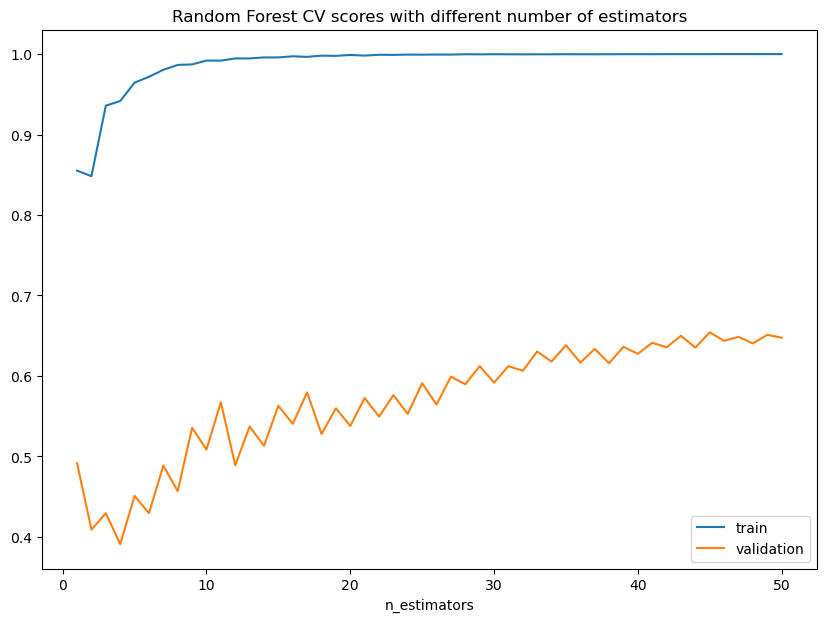

In [37]:
plt.figure(figsize=(10, 7))
results.plot(x="n_estimators", y=["train", "validation"], kind="line", ax=plt.gca())
plt.legend()
plt.title("Random Forest CV scores with different number of estimators")
plt.show()

Definitely overfitting here, let's try tuning `max_depth` with the best value from the above graph:

In [38]:
# Getting the best validation score
max_x = results.loc[results['validation'].idxmax()]
max_x

n_estimators    45.000000
train            0.999943
validation       0.654214
Name: 44, dtype: float64

Let's further tune this model with a `n_estimators` of 49:

In [39]:
max_depths = range(1, 31)
results = pd.DataFrame()
for depth in max_depths:
    # Instantiate the model
    rf = RandomForestClassifier(n_estimators = 49, max_depth=depth, random_state=10)
    
    # Fit the model
    rf.fit(X_train_ss, y_train)
    
    # Score the model and append to lists
    train_score = rf.score(X_train_ss, y_train)
    val_score = rf.score(X_val_ss, y_val)
    
    results = results.append(
    {'max_depth': depth, 'train': train_score, 'validation': val_score}, ignore_index=True)
    
    print(depth, end='\r')


Now to plot these results:

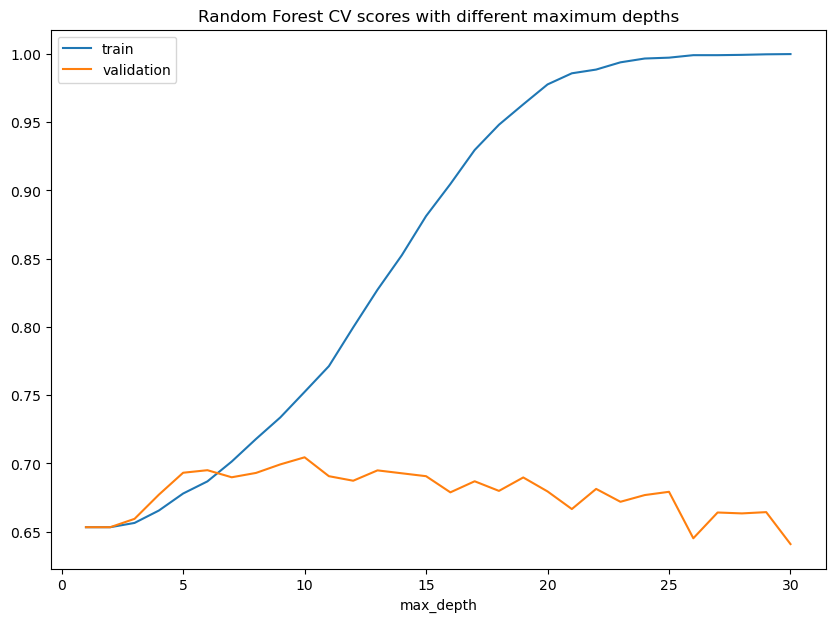

In [40]:
plt.figure(figsize=(10, 7))
results.plot(x="max_depth", y=["train", "validation"], kind="line", ax=plt.gca())
plt.legend()
plt.title("Random Forest CV scores with different maximum depths")
plt.show()

In [41]:
# Getting the best validation score
max_depth = results.loc[results['validation'].idxmax()]
max_depth

max_depth     10.000000
train          0.752365
validation     0.704467
Name: 9, dtype: float64

Ok, for our final model we will use `n_estimators` = 49 and `max_depth` = 14.

In [42]:
# Instantiate the model
final_rf = RandomForestClassifier(max_depth=14, n_estimators=49, random_state=10)

# Fit the model
final_rf.fit(X_train_ss, y_train)

# Score the model
train_score = final_rf.score(X_train_ss, y_train)
test_score = final_rf.score(X_test_ss, y_test)

And to print the results:

In [43]:
print(f'Training Score: {train_score}')
print(f'Testing Score: {test_score}')

Training Score: 0.8524216524216525
Testing Score: 0.6876046901172529


That model also appears to be overfitting with the large delta between training and testing accuracy. Let's add this result to our DataFrame and plot the confusion matrix:


In [44]:
add_results(final_rf, model_comparison_df, X_test_ss, y_test, 'Tuned Random Forest', 'first tuned RF')

,Model Instance,description,precision,recall,F1
0,DT_w_predictors,First DT Model,0.888509,0.926353,0.907037
1,DT_w_tuning,Second DT Model,0.710857,0.894444,0.792153
2,Tuned Random Forest,first tuned RF,0.724862,0.841026,0.778635


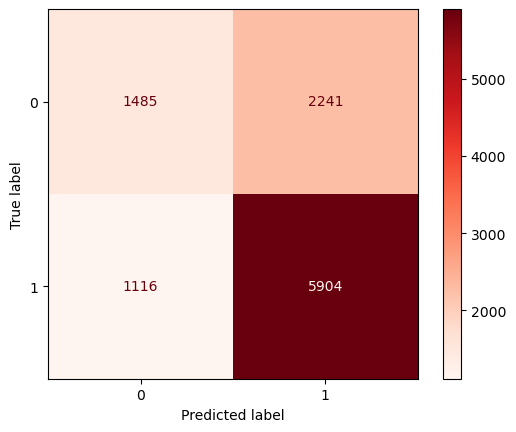

In [45]:
plot_confusion_matrix(final_rf, X_test_ss, y_test, cmap='Reds');

Similar to our last decision tree model, the random forest model also has a high false positive rate. That will conclude our foray into random forest models. We will not be trying a Gradient Boosting model:

## Gradient Boosting Model

In [46]:
from sklearn.ensemble import GradientBoostingClassifier

Let's try a gradient boosting model without modifying any of it's hyperparameters:

In [47]:
# Instantiate the model
grad_boost = GradientBoostingClassifier(random_state=10)

#Fit the model
grad_boost.fit(X_train_ss, y_train)

# Score the model
train_score = grad_boost.score(X_train_ss, y_train)
val_score = grad_boost.score(X_val_ss, y_val)

And now to print the results:


In [48]:
print(f'Training Score on Basic Gradient Boost Model: {train_score}')
print(f'Validation Score on Basic Gradient Boost Model: {val_score}')

Training Score on Basic Gradient Boost Model: 0.7402279202279203
Validation Score on Basic Gradient Boost Model: 0.6979526721616591


Not bad! Right off the bat this model is doing pretty well. Let's look at our evaluation metrics:


In [49]:
grad_boost.score(X_test_ss, y_test)

0.6863949376512191

In [50]:
add_results(grad_boost, model_comparison_df, X_test_ss, y_test, 'Gradient Boosting', 'out of the box')

,Model Instance,description,precision,recall,F1
0,DT_w_predictors,First DT Model,0.888509,0.926353,0.907037
1,DT_w_tuning,Second DT Model,0.710857,0.894444,0.792153
2,Tuned Random Forest,first tuned RF,0.724862,0.841026,0.778635
3,Gradient Boosting,out of the box,0.777187,0.728917,0.752279


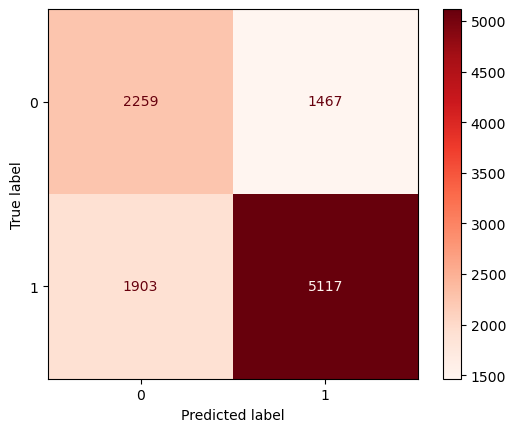

In [51]:
plot_confusion_matrix(grad_boost, X_test_ss, y_test, cmap='Reds');

Not a bad confusion matrix here, roughly an equal amount of false positives and false negatives. That model did take awhile to run though. There is a similar model type called the XGBoost model that performs roughly the same and is much quicker than the gradient boost model.

## XGBoost Model

In [52]:
from xgboost import XGBClassifier

Let's also try this model out of the box:

In [53]:
xgb_model = XGBClassifier(random_state=10)

xgb_model.fit(X_train_ss, y_train)
xgb_model.score(X_train_ss, y_train)

0.9135612535612536

In [54]:
xgb_model.score(X_val_ss, y_val)

0.6692369050784366

In [55]:
xgb_model.score(X_test_ss, y_test)

0.6804392332030523

Not bad! This model performed roughly the same as our Gradient Boosting model, but does seem to be largely overfitting. Let's look at our evaluation metrics:

In [56]:
add_results(xgb_model, model_comparison_df, X_test_ss, y_test, 'First XGBoost', 'out of the box')

,Model Instance,description,precision,recall,F1
0,DT_w_predictors,First DT Model,0.888509,0.926353,0.907037
1,DT_w_tuning,Second DT Model,0.710857,0.894444,0.792153
2,Tuned Random Forest,first tuned RF,0.724862,0.841026,0.778635
3,Gradient Boosting,out of the box,0.777187,0.728917,0.752279
4,First XGBoost,out of the box,0.730641,0.809117,0.767879


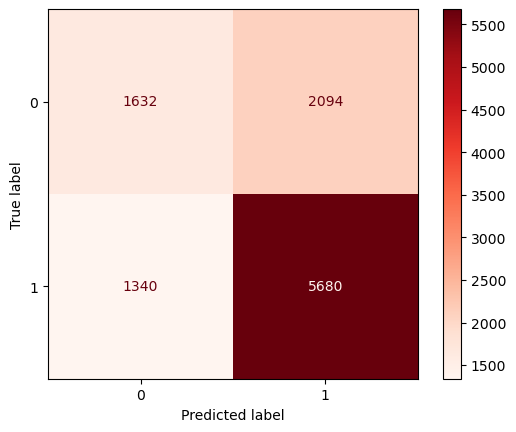

In [57]:
plot_confusion_matrix(xgb_model, X_test_ss, y_test, cmap='Reds');

This is a similar confusion matrix to our Gradient Boosting model. Let's tune the hyperparameters of this model and see if we can improve any of it's scores. We can do this by doing a grid search:

In [58]:
from sklearn.model_selection import GridSearchCV

We will try out a few different parameters:
- `n_estimators` ranging from 1 to 500 in increments of 100
- `max_depth` ranging from 1 to 5

**Warning: The below cell will take a while to run**

In [59]:
my_xgb = XGBClassifier(n_jobs=-1)

param_grid = {'n_estimators': np.arange(1, 501, 100), 'max_depth': np.arange(1, 5)}

grid_xgb = GridSearchCV(my_xgb, param_grid=param_grid, verbose=3, n_jobs=-1, cv=5)

grid_xgb.fit(X_train_ss, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=-1,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, ...),
             n_jobs=-1,
             param_grid={'max_depth': array([1, 2, 3, 4]),
                         'n_estimators': array([  1, 101, 201, 301, 401])},
             verbose=3)

We can return the best estimators for this grid search using the `best_params` method:

In [60]:
grid_xgb.best_params_

{'max_depth': 2, 'n_estimators': 301}

To further refine our search:

In [61]:
my_xgb = XGBClassifier(n_jobs=-1)

param_grid = {'n_estimators': np.arange(295, 306), 'booster': ['gbtree', 'gblinear', 'dart']}

grid_xgb = GridSearchCV(my_xgb, param_grid=param_grid, verbose=3, n_jobs=-1, cv=5)

grid_xgb.fit(X_train, y_train)

Fitting 5 folds for each of 33 candidates, totalling 165 fits
[CV 2/5] END .....max_depth=1, n_estimators=101;, score=0.704 total time=   9.9s
[CV 5/5] END .....max_depth=1, n_estimators=201;, score=0.719 total time=  20.2s
[CV 2/5] END .....max_depth=1, n_estimators=401;, score=0.716 total time=  39.4s
[CV 4/5] END .....max_depth=2, n_estimators=201;, score=0.711 total time=  33.1s
[CV 2/5] END .....max_depth=2, n_estimators=401;, score=0.721 total time= 1.1min
[CV 1/5] END .....max_depth=3, n_estimators=201;, score=0.714 total time=  47.1s
[CV 4/5] END .....max_depth=3, n_estimators=301;, score=0.706 total time= 1.2min
[CV 2/5] END .....max_depth=4, n_estimators=101;, score=0.714 total time=  27.3s
[CV 1/5] END .....max_depth=4, n_estimators=201;, score=0.712 total time=  49.5s
[CV 4/5] END .....max_depth=4, n_estimators=301;, score=0.706 total time= 1.3min
[CV 2/5] END ..booster=gbtree, n_estimators=295;, score=0.699 total time= 1.9min
[CV 4/5] END ..booster=gbtree, n_estimators=296

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_ca...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=-1,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, ...),
             n_jobs=-1,
             param_grid={'booster': ['gbtree', 'gblinear', 'dart'],
                         'n_estimators': array([295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305])},
             verbose=3)

In [62]:
grid_xgb.best_params_

{'booster': 'gbtree', 'n_estimators': 302}

From the two grid searches that we have done, we have found the best parameters to be:
- `n_estimators` = 296
- `max_depth` = 1
- `booster` = gbtree

In [63]:
final_xgb = XGBClassifier(max_depth=1, n_estimators=296, booster='gbtree')

final_xgb.fit(X_train_ss, y_train)

final_xgb.score(X_train_ss, y_train)

0.7312250712250712

In [64]:
final_xgb.score(X_val_ss, y_val)

0.6851901090135603

In [65]:
final_xgb.score(X_test_ss, y_test)

0.6873255164712451

Not so great results on the validation and testing sets, but let's take a look at our evaluation metrics:

In [66]:
add_results(final_xgb, model_comparison_df, X_test_ss, y_test, 'Tuned XGBoost', 'max_depth=1, n_estimators=296')

,Model Instance,description,precision,recall,F1
0,DT_w_predictors,First DT Model,0.888509,0.926353,0.907037
1,DT_w_tuning,Second DT Model,0.710857,0.894444,0.792153
2,Tuned Random Forest,first tuned RF,0.724862,0.841026,0.778635
3,Gradient Boosting,out of the box,0.777187,0.728917,0.752279
4,First XGBoost,out of the box,0.730641,0.809117,0.767879
5,Tuned XGBoost,"max_depth=1, n_estimators=296",0.772565,0.738889,0.755352


Not bad! That's one of our better performing models so far. Let's see where the model went wrong with the confusion matrix:

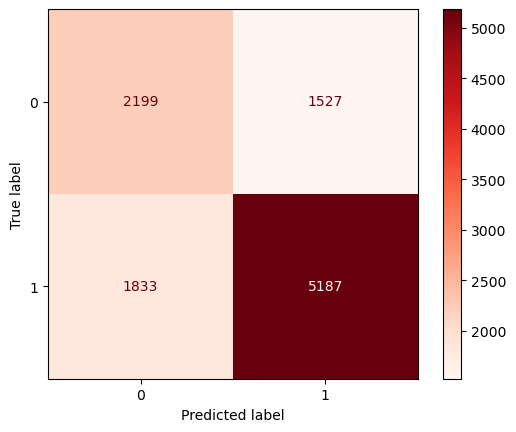

In [67]:
plot_confusion_matrix(final_xgb, X_test_ss, y_test, cmap='Reds');

That's interesting, this model had more false negatives than false positives which is something that we haven't really seen yet. We could try and tune the hyperparameters of this model more, as this model does respond well to fine hyperparameter tuning, but for now we will leave it here. The next model that we will try is Logistic Regression. A staple baseline model.

## Logistic Regression

In [68]:
from sklearn.linear_model import LogisticRegression

We will want to loop over various values for `C` which is the inverse of the regularization strength.

In [69]:
cs = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100] #Values to loop over
train_acc = []
val_acc = []

for c in cs:
    
    # Instantiate the model
    logit = LogisticRegression(C=c)
    
    # Fit the model
    logit.fit(X_train_ss, y_train)
    
    # Score the model and append to the respective lists
    train_acc.append(logit.score(X_train_ss, y_train))
    val_acc.append(logit.score(X_val_ss, y_val))
    

Now we can plot these results:

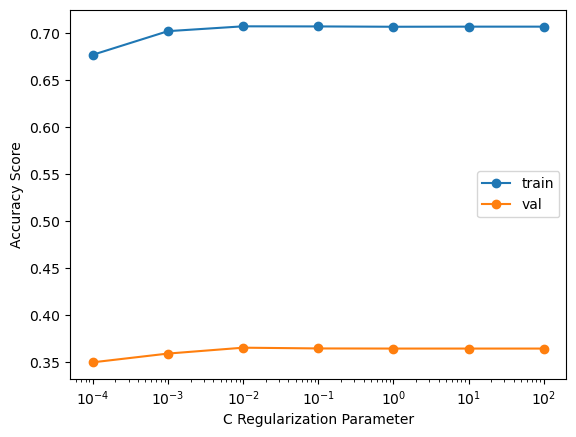

In [70]:
plt.figure()
plt.plot(cs, train_acc, label='train', marker='o') #plotting train accuracies
plt.plot(cs, val_acc, label='val', marker='o') #plotting validation accuracies
plt.legend()
plt.ylabel('Accuracy Score')
plt.xlabel('C Regularization Parameter')
plt.xscale('log')
plt.show()

That has been the worst performing model we have seen thus far. We will add these results to our DataFrame, but we will not be pursuing this model any further.

In [71]:
add_results(logit, model_comparison_df, X_test_ss, y_test, 'First Logistic Regression', 'tuned C only')

,Model Instance,description,precision,recall,F1
0,DT_w_predictors,First DT Model,0.888509,0.926353,0.907037
1,DT_w_tuning,Second DT Model,0.710857,0.894444,0.792153
2,Tuned Random Forest,first tuned RF,0.724862,0.841026,0.778635
3,Gradient Boosting,out of the box,0.777187,0.728917,0.752279
4,First XGBoost,out of the box,0.730641,0.809117,0.767879
5,Tuned XGBoost,"max_depth=1, n_estimators=296",0.772565,0.738889,0.755352
6,First Logistic Regression,tuned C only,0.602241,0.061254,0.111197


Let's look at the confusion matrix for Logistic Regression

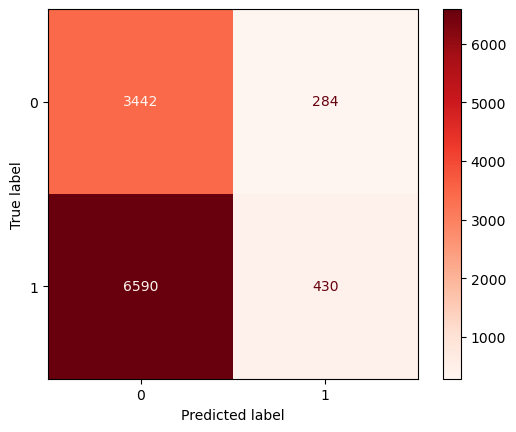

In [72]:
plot_confusion_matrix(logit, X_test_ss, y_test, cmap='Reds');

Wow, that must be the highest false negative rate that we have seen so far. This model was not able to accurately predict the positive class very well at all. It did do pretty well on predicting true negatives however. If there was a way to increase the true positive rate while maintaning the true negative rate, this model could be looked into further.

-----------

Another common model that is often used for classification is support vector machines. We will implement that model here.

## Support Vector Machines

We will try this model using the kernel trick. Which is a way for a SVM model to identify non-linear relationships. More information on the kernel trick can be found here: https://en.wikipedia.org/wiki/Kernel_method

In [73]:
from sklearn.svm import SVC
# instantiating two different models, each with a different kernel
my_RBF_kernel_SVM = SVC(kernel='rbf') # the default kernel is a Radial Basis Function transformation
my_linear_kernel_SVM = SVC(kernel='linear')

In [74]:
#Fit the data
my_linear_kernel_SVM.fit(X_train_ss, y_train)

#Get the score
print(f"Linear SVM score (train): {my_linear_kernel_SVM.score(X_train_ss ,y_train)}")
print(f"Linear SVM score (validation): {my_linear_kernel_SVM.score(X_val_ss, y_val)}")

[CV 2/5] END .......max_depth=1, n_estimators=1;, score=0.653 total time=   0.6s
[CV 4/5] END .....max_depth=1, n_estimators=101;, score=0.709 total time=  10.0s
[CV 3/5] END .....max_depth=1, n_estimators=301;, score=0.719 total time=  30.1s
[CV 1/5] END .......max_depth=2, n_estimators=1;, score=0.696 total time=   0.7s
[CV 2/5] END .......max_depth=2, n_estimators=1;, score=0.683 total time=   0.7s
[CV 3/5] END .......max_depth=2, n_estimators=1;, score=0.686 total time=   0.6s
[CV 4/5] END .......max_depth=2, n_estimators=1;, score=0.695 total time=   0.5s
[CV 5/5] END .......max_depth=2, n_estimators=1;, score=0.682 total time=   0.6s
[CV 1/5] END .....max_depth=2, n_estimators=101;, score=0.724 total time=  18.6s
[CV 5/5] END .....max_depth=2, n_estimators=101;, score=0.720 total time=  18.2s
[CV 3/5] END .....max_depth=2, n_estimators=301;, score=0.723 total time=  43.7s
[CV 1/5] END .......max_depth=3, n_estimators=1;, score=0.701 total time=   0.6s
[CV 2/5] END .......max_dept

[CV 3/5] END .......max_depth=1, n_estimators=1;, score=0.653 total time=   0.8s
[CV 1/5] END .....max_depth=1, n_estimators=201;, score=0.726 total time=  20.3s
[CV 5/5] END .....max_depth=1, n_estimators=301;, score=0.721 total time=  28.7s
[CV 3/5] END .....max_depth=2, n_estimators=101;, score=0.716 total time=  18.7s
[CV 2/5] END .....max_depth=2, n_estimators=201;, score=0.723 total time=  33.7s
[CV 5/5] END .....max_depth=2, n_estimators=301;, score=0.717 total time=  48.9s
[CV 3/5] END .....max_depth=3, n_estimators=101;, score=0.724 total time=  23.0s
[CV 3/5] END .....max_depth=3, n_estimators=201;, score=0.717 total time=  48.5s
[CV 1/5] END .....max_depth=3, n_estimators=401;, score=0.709 total time= 1.5min
[CV 5/5] END .....max_depth=4, n_estimators=101;, score=0.719 total time=  25.1s
[CV 1/5] END .....max_depth=4, n_estimators=301;, score=0.711 total time= 1.3min
[CV 4/5] END .....max_depth=4, n_estimators=401;, score=0.690 total time= 1.3min
[CV 4/5] END ..booster=gbtre

[CV 4/5] END .......max_depth=1, n_estimators=1;, score=0.653 total time=   0.9s
[CV 3/5] END .....max_depth=1, n_estimators=201;, score=0.717 total time=  20.5s
[CV 1/5] END .....max_depth=1, n_estimators=401;, score=0.723 total time=  39.3s
[CV 4/5] END .....max_depth=2, n_estimators=101;, score=0.711 total time=  18.3s
[CV 5/5] END .....max_depth=2, n_estimators=201;, score=0.719 total time=  31.0s
[CV 3/5] END .....max_depth=2, n_estimators=401;, score=0.721 total time= 1.1min
[CV 4/5] END .....max_depth=3, n_estimators=201;, score=0.710 total time=  48.3s
[CV 2/5] END .....max_depth=3, n_estimators=401;, score=0.721 total time= 1.5min
[CV 2/5] END .....max_depth=4, n_estimators=201;, score=0.718 total time=  49.4s
[CV 5/5] END .....max_depth=4, n_estimators=301;, score=0.711 total time= 1.3min
[CV 3/5] END ..booster=gbtree, n_estimators=296;, score=0.703 total time= 1.9min
[CV 3/5] END ..booster=gbtree, n_estimators=297;, score=0.703 total time= 1.8min
[CV 3/5] END ..booster=gbtre

That might be the worst score we have seen yet on the validation set. Let's see how it does on the testing set:

In [75]:
my_linear_kernel_SVM.score(X_test_ss, y_test)

0.37316210683044854

Still not great results. Nonetheless, we will still add this model to our DataFrame.

In [76]:
add_results(my_linear_kernel_SVM, model_comparison_df, X_test_ss, y_test, 'SVM Linear Kernel', 'out of the box')

,Model Instance,description,precision,recall,F1
0,DT_w_predictors,First DT Model,0.888509,0.926353,0.907037
1,DT_w_tuning,Second DT Model,0.710857,0.894444,0.792153
2,Tuned Random Forest,first tuned RF,0.724862,0.841026,0.778635
3,Gradient Boosting,out of the box,0.777187,0.728917,0.752279
4,First XGBoost,out of the box,0.730641,0.809117,0.767879
5,Tuned XGBoost,"max_depth=1, n_estimators=296",0.772565,0.738889,0.755352
6,First Logistic Regression,tuned C only,0.602241,0.061254,0.111197
7,SVM Linear Kernel,out of the box,0.691892,0.072934,0.131959


And to look at the confusion matrix:

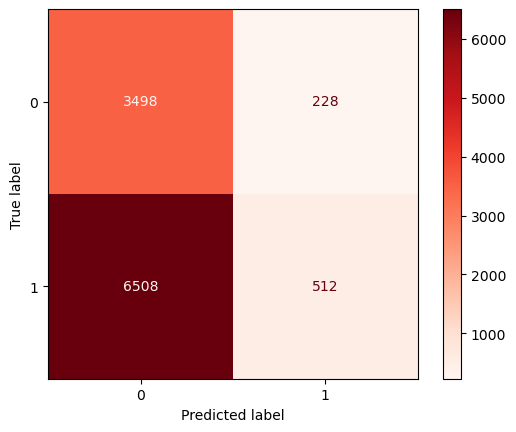

In [77]:
plot_confusion_matrix(my_linear_kernel_SVM, X_test_ss, y_test, cmap='Reds');

Interesting, this model is biased towards predicting 0 for most values. It did pretty well in predicting true negatives but also had a very high false negative rate. With only 410 true positives detected, and the extremely long runtime of this model, this model is not a good model to use for our case.

Let's try the other SVM that was created above:

In [78]:
my_RBF_kernel_SVM.fit(X_train_ss, y_train)

train_score = my_RBF_kernel_SVM.score(X_train_ss, y_train)
val_score = my_RBF_kernel_SVM.score(X_val_ss, y_val)

And now to print the results:

In [79]:
print(train_score)
print(val_score)

0.7663247863247863
0.6532837011433129


That is much better than the previous SVM model, however this model seems to be overfitting a bit. Let's see how it does on the testing set:

In [80]:
my_RBF_kernel_SVM.score(X_test_ss, y_test)

0.6532663316582915

That is pretty much in line with our baseline accuracy score. Let's look at the other metrics and the confusion matrix:

In [81]:
add_results(my_RBF_kernel_SVM, model_comparison_df, X_test_ss, y_test, 'SVM RBF Kernel', 'out of the box')

,Model Instance,description,precision,recall,F1
0,DT_w_predictors,First DT Model,0.888509,0.926353,0.907037
1,DT_w_tuning,Second DT Model,0.710857,0.894444,0.792153
2,Tuned Random Forest,first tuned RF,0.724862,0.841026,0.778635
3,Gradient Boosting,out of the box,0.777187,0.728917,0.752279
4,First XGBoost,out of the box,0.730641,0.809117,0.767879
5,Tuned XGBoost,"max_depth=1, n_estimators=296",0.772565,0.738889,0.755352
6,First Logistic Regression,tuned C only,0.602241,0.061254,0.111197
7,SVM Linear Kernel,out of the box,0.691892,0.072934,0.131959
8,SVM RBF Kernel,out of the box,0.653266,1.000000,0.790274


Wow, that got a perfect recall! Let's see the confusion matrix:

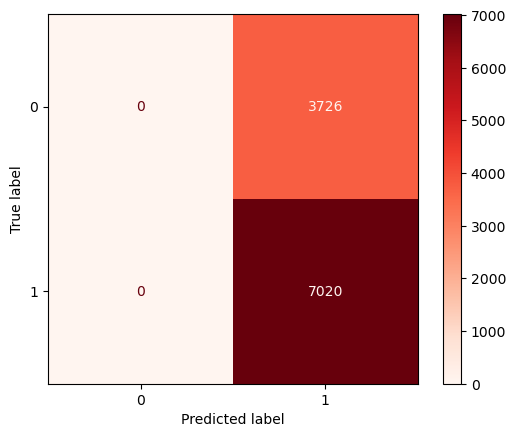

In [82]:
plot_confusion_matrix(my_RBF_kernel_SVM, X_test_ss, y_test, cmap='Reds');

**Interpretation**: This model did not predict any actual 0 values correctly, nor did it predict any False Negatives. A model that only predicts the positive class is perfectly in line with our baseline accuracy, which is not what we are after.

-------

Due to the computationally expensive runtimes, and subpar results, we will not be pursuing support vector machines anymore in this notebook. Let's try a simple neural network for our next model.

## Deep Learning

For this model, we will be using TensorFlow. Another popular library for neural networks is Pytorch, but for ease of use, we will be using tensorflow here:

In [83]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

For our data to work in a tensorflow model, we will have to convert the X datasets to float datatypes, and reshape our y datasets.

In [84]:

X_train_nn = np.array(X_train_ss, dtype=np.float32) # changing datatype
y_train_nn = np.array(y_train, dtype=np.float32).reshape((-1, 1)) #reshaping the array

# applying the above to the rest of our data
X_test_nn = np.array(X_test_ss, dtype=np.float32)
y_test_nn = np.array(y_test, dtype=np.float32).reshape((-1, 1))
X_val_nn = np.array(X_val_ss, dtype=np.float32)
y_val_nn = np.array(y_val, dtype=np.float32).reshape((-1, 1))

Let's look at the shape of `y_train` to ensure that our changes were implemented.

In [85]:
y_train_nn.shape

(17550, 1)

Looks like that has worked, let's set up our model.

In [86]:
model = keras.Sequential() # Standard model type for a simple neural network

# Declare the hidden layers
model.add(layers.Dense(30, activation="relu")) # Adding dense layers with the relu activation function
model.add(layers.Dense(60, activation="relu"))
model.add(layers.Dense(30, activation="relu"))
model.add(layers.Dense(29, activation="relu"))
model.add(layers.Dense(28, activation="relu"))
model.add(layers.Dense(27, activation="relu"))
model.add(layers.Dense(26, activation="relu"))


# Declare the output layer - one output for predicting the probability of class 1
model.add(layers.Dense(1, activation="sigmoid"))

2022-10-06 17:08:30.068550: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [87]:
model.compile(
    # Optimizer
    optimizer='adam',  
    # Loss function to minimize
    loss='binary_crossentropy', # standard choice for binary classification with 1 output node
    # Metric used to evaluate model
    metrics=['binary_accuracy']
)

Now that our model is set up and compiled, we can fun our model using the `fit` method:

In [88]:
history = model.fit(X_train_nn, y_train_nn, epochs=100, verbose=1)

Epoch 1/100
549/549 [==============================] - 1s 787us/step - loss: 0.6081 - binary_accuracy: 0.6670
Epoch 2/100
549/549 [==============================] - 0s 778us/step - loss: 0.5603 - binary_accuracy: 0.7022
Epoch 3/100
549/549 [==============================] - 0s 768us/step - loss: 0.5389 - binary_accuracy: 0.7214
Epoch 4/100
549/549 [==============================] - 0s 768us/step - loss: 0.5196 - binary_accuracy: 0.7378
Epoch 5/100
549/549 [==============================] - 0s 770us/step - loss: 0.4976 - binary_accuracy: 0.7505
Epoch 6/100
549/549 [==============================] - 0s 765us/step - loss: 0.4760 - binary_accuracy: 0.7652
Epoch 7/100
549/549 [==============================] - 0s 767us/step - loss: 0.4492 - binary_accuracy: 0.7846
Epoch 8/100
549/549 [==============================] - 0s 768us/step - loss: 0.4270 - binary_accuracy: 0.7964
Epoch 9/100
549/549 [==============================] - 0s 766us/step - loss: 0.4033 - binary_accuracy: 0.8107
Epoch 10/1

549/549 [==============================] - 0s 772us/step - loss: 0.0672 - binary_accuracy: 0.9770
Epoch 75/100
549/549 [==============================] - 0s 773us/step - loss: 0.0724 - binary_accuracy: 0.9740
Epoch 76/100
549/549 [==============================] - 0s 775us/step - loss: 0.0642 - binary_accuracy: 0.9774
Epoch 77/100
549/549 [==============================] - 0s 771us/step - loss: 0.0652 - binary_accuracy: 0.9757
Epoch 78/100
549/549 [==============================] - 0s 778us/step - loss: 0.0681 - binary_accuracy: 0.9752
Epoch 79/100
549/549 [==============================] - 0s 780us/step - loss: 0.0657 - binary_accuracy: 0.9765
Epoch 80/100
549/549 [==============================] - 0s 794us/step - loss: 0.0672 - binary_accuracy: 0.9749
Epoch 81/100
549/549 [==============================] - 0s 782us/step - loss: 0.0638 - binary_accuracy: 0.9773
Epoch 82/100
549/549 [==============================] - 0s 786us/step - loss: 0.0641 - binary_accuracy: 0.9765
Epoch 83/100
5

In [89]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 30)                13770     
                                                                 
 dense_1 (Dense)             (None, 60)                1860      
                                                                 
 dense_2 (Dense)             (None, 30)                1830      
                                                                 
 dense_3 (Dense)             (None, 29)                899       
                                                                 
 dense_4 (Dense)             (None, 28)                840       
                                                                 
 dense_5 (Dense)             (None, 27)                783       
                                                                 
 dense_6 (Dense)             (None, 26)                7

In [90]:
# Evaluate the network
train_accuracy = history.history["binary_accuracy"][-1]
result = model.evaluate(X_test_ss, y_test, verbose=0)

print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {result[1]:.4f}") 

# Generate predictions
predictions = model.predict(X_test_ss)

Train Accuracy: 0.9800
Test Accuracy: 0.5076


That model is way overfitting and we are not even predicting the baseline for the test set. It is also predicting that almost all of the values are 1. Let's run it again, but with our validation data and a few tweaks. First we will look at the confusion matrix and add the results of this model to our model evaluation DataFrame

In [91]:
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.math import confusion_matrix

In [92]:
import seaborn as sns
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

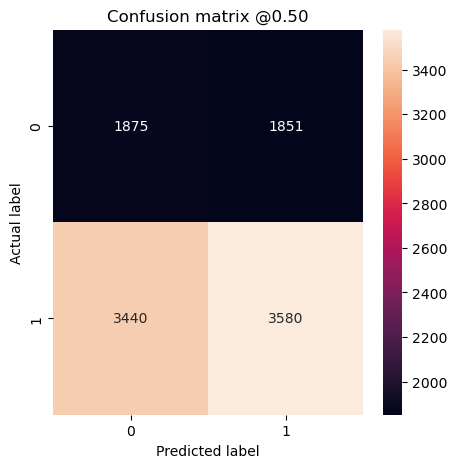

In [93]:
cm = confusion_matrix(y_test, predictions>0.5)
plot_cm(y_test, predictions)


This model is almost the opposite of our SVM models. This model leaned heavily towards predicting the negative class, with very little values being predicted as positive, whether that be false positives or true positives.

-------

To add these values to our DataFrame, we will have to calculate the precision, recall and F1 Score manually.

In [94]:
np.sum(cm[0][0]) #True negatives

1875

In [95]:
np.sum(cm[1][1]) #True positives

3580

In [96]:
np.sum(cm[0][1]) #False positives

1851

In [97]:
np.sum(cm[1][0]) #False negatives


3440

Below we define the manual functions for our precision, recall and F1 score.

In [98]:
def precision(cm):
    tn = np.sum(cm[0][0]) #True negatives
    fp = np.sum(cm[0][1]) #False positives
    fn = np.sum(cm[1][0]) #False negatives
    tp = np.sum(cm[1][1]) # true positives
    
    return (tp) / (tp+fp) # Precision formula

In [99]:
def recall(cm):
    tn = np.sum(cm[0][0]) #True negatives
    fp = np.sum(cm[0][1]) #False positives
    fn = np.sum(cm[1][0]) #False negatives
    tp = np.sum(cm[1][1]) # true positives
    
    return (tp)/(tp+fn) # recall score

In [100]:
def f1score(precision, recall):
    return (2*((precision*recall)/(precision+recall))) # formula for f1 score

In [101]:
precision = precision(cm)


In [102]:
recall = recall(cm)

In [103]:
f1score = f1score(precision, recall)
f1score

0.5750542125130512

Let's put these results into a list, since we cannot use them in our custom function to add them to our dataframe.

In [104]:
data = ['First Neural Net', '7 hidden layers, various nodes each, 100 epochs', precision,
       recall, f1score]
data

['First Neural Net',
 '7 hidden layers, various nodes each, 100 epochs',
 0.6591787884367519,
 0.50997150997151,
 0.5750542125130512]

We can add these values to our dataframe by appending them as the last row.

In [105]:
model_comparison_df.loc[len(model_comparison_df)] = data
model_comparison_df

,Model Instance,description,precision,recall,F1
0,DT_w_predictors,First DT Model,0.888509,0.926353,0.907037
1,DT_w_tuning,Second DT Model,0.710857,0.894444,0.792153
2,Tuned Random Forest,first tuned RF,0.724862,0.841026,0.778635
3,Gradient Boosting,out of the box,0.777187,0.728917,0.752279
4,First XGBoost,out of the box,0.730641,0.809117,0.767879
5,Tuned XGBoost,"max_depth=1, n_estimators=296",0.772565,0.738889,0.755352
6,First Logistic Regression,tuned C only,0.602241,0.061254,0.111197
7,SVM Linear Kernel,out of the box,0.691892,0.072934,0.131959
8,SVM RBF Kernel,out of the box,0.653266,1.000000,0.790274
9,First Neural Net,"7 hidden layers, various nodes each, 100 epochs",0.659179,0.509972,0.575054


It is interesting to note the insanely low recall score for this model. If there was more time for this project, neural networks could be explored more, however we already have models that perform better and will use those for our final model.

## Model Selection

Overall we are using three metrics to gauge our models:

- Precision: The fraction of positive predictions that are correct. Maximizing this limits false positives
- Recall: The fraction of positive cases that were predicted as positive. Maximizing this limits false negatives
- F1 Score: The harmonic mean of precision and recall, important if you care about the positive class in both precision and recall equally

------

**Remember: Our goal of the project is to identify hosts that have bad review scores**

With the imbalance of the data, It is more important to limit the amount of false positives, or in more general terms: hosts who have bad review scores that are predicted to have good review scores.

-----

With that being said, the model that maximized precision (outside of the first model which had the collinear predictors), and F1 Score second was the Gradient Boosting model that was ran. This is the model that we will select. 

In [106]:
model_comparison_df.sort_values(by=['precision', 'F1'], ascending=False)

,Model Instance,description,precision,recall,F1
0,DT_w_predictors,First DT Model,0.888509,0.926353,0.907037
3,Gradient Boosting,out of the box,0.777187,0.728917,0.752279
5,Tuned XGBoost,"max_depth=1, n_estimators=296",0.772565,0.738889,0.755352
4,First XGBoost,out of the box,0.730641,0.809117,0.767879
2,Tuned Random Forest,first tuned RF,0.724862,0.841026,0.778635
1,DT_w_tuning,Second DT Model,0.710857,0.894444,0.792153
7,SVM Linear Kernel,out of the box,0.691892,0.072934,0.131959
9,First Neural Net,"7 hidden layers, various nodes each, 100 epochs",0.659179,0.509972,0.575054
8,SVM RBF Kernel,out of the box,0.653266,1.000000,0.790274
6,First Logistic Regression,tuned C only,0.602241,0.061254,0.111197


We will try to tune the hyperparameters of this model since our first instance was just out of the box.

In [107]:
from sklearn.ensemble import GradientBoostingClassifier

In [108]:
grad_boost = GradientBoostingClassifier(random_state=10)

grad_boost.fit(X_train_ss, y_train)

train_score = grad_boost.score(X_train_ss, y_train)
val_score = grad_boost.score(X_val_ss, y_val)

In [109]:
print(f'Training Score on Basic Gradient Boost Model: {train_score}')
print(f'Validation Score on Basic Gradient Boost Model: {val_score}')

Training Score on Basic Gradient Boost Model: 0.7402279202279203
Validation Score on Basic Gradient Boost Model: 0.6979526721616591


Let's see how this model does on the testing data again:

In [110]:
grad_boost.score(X_test_ss, y_test)

0.6863949376512191

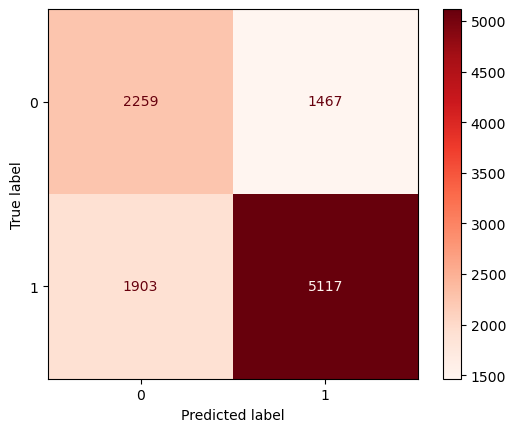

In [111]:
plot_confusion_matrix(grad_boost, X_test_ss, y_test, cmap='Reds');

All of this data has already been seen in the earlier part of the notebook, we will continue onto hyperparameter optimization here.

In [112]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, accuracy_score

In [113]:
gbm1 = GradientBoostingClassifier(random_state=10)

Below we will run a cross validation on this model, and look at what features are the most important predictors for this model. We will also use the roc_auc score here, which provides an aggregate measure of performance across all possible classification thresholds.

In [114]:
    #Fit the algorithm on the data
gbm1.fit(X_train_ss, y_train)
        
    #Predict training set:
train_predictions = gbm1.predict(X_train_ss)
train_predprob = gbm1.predict_proba(X_train_ss)[:,1]
    
    #Perform cross-validation:

cv_score = cross_val_score(gbm1, X_train_ss, y_train, cv=5, scoring='roc_auc')
    
    #Print model report:
print("\nModel Report")
print("Accuracy : %.4g" % accuracy_score(y_train, train_predictions))
print("AUC Score (Train): %f" % roc_auc_score(y_train, train_predprob))
    

print("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
        



Model Report
Accuracy : 0.7402
AUC Score (Train): 0.796945
CV Score : Mean - 0.756821 | Std - 0.008211868 | Min - 0.7475295 | Max - 0.7704727


In [115]:
gbm1.feature_importances_.shape

(458,)

Let's convert these feature importances to a series so we can eventually plot them:

In [116]:
feat_imp = pd.Series(gbm1.feature_importances_, X_train.columns).sort_values(ascending=False)
feat_imp

host_is_superhost                        0.273369
calculated_host_listings_count           0.133719
number_of_reviews                        0.074720
host_since                               0.054481
host_total_listings_count                0.047678
                                           ...   
ohe__neighborhood_Morrisania             0.000000
ohe__neighborhood_Morris Park            0.000000
ohe__neighborhood_Morris Heights         0.000000
ohe__neighborhood_Morningside Heights    0.000000
ohe__neighborhood_SoHo                   0.000000
Length: 458, dtype: float64

Text(0, 0.5, 'Feature Importance Score')

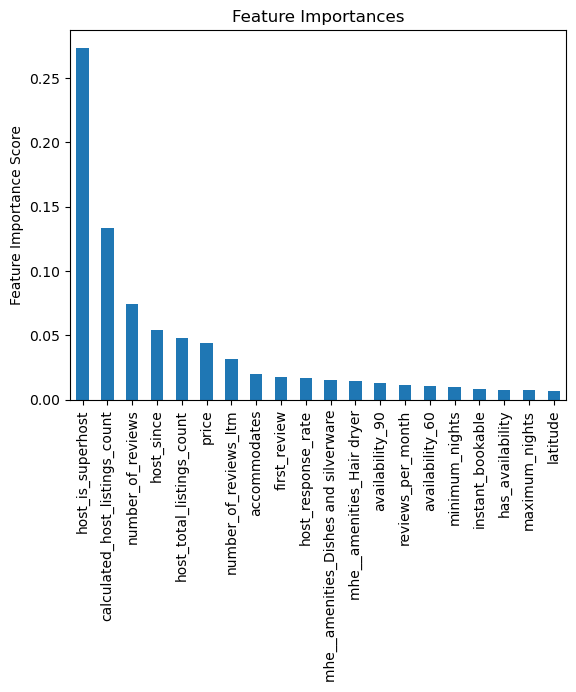

In [117]:
    #Print Feature Importance:
feat_imp = pd.Series(gbm1.feature_importances_, X_train.columns).sort_values(ascending=False)[:20]
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

Some typical predictors here are expected. Things like `host_is_superhost`, `number_of_reviews` and `host_since` are all things that people might expect to influence a host's review score. It is interesting to see various amenities such as dishes & silverware, and hair dryers making the list.

Let's perform another grid search over some basic hyperparameters for this Gradient Boosting model.

------

**PLEASE NOTE: The below cell takes a long time to finish running.**

In [118]:
parameters = {'n_estimators': [100, 300, 600, 900],
             'min_samples_split': [2, 4, 6, 8],
             'min_samples_leaf': [1, 3, 5]}
estimator=GradientBoostingClassifier(random_state=10)
clf = GridSearchCV(estimator, parameters, verbose=3)
clf.fit(X_train_ss, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV 1/5] END min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.715 total time=  15.1s
[CV 2/5] END min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.705 total time=  15.1s
[CV 3/5] END min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.721 total time=  15.1s
[CV 4/5] END min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.713 total time=  15.2s
[CV 5/5] END min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.712 total time=  15.1s
[CV 1/5] END min_samples_leaf=1, min_samples_split=2, n_estimators=300;, score=0.723 total time=  46.3s
[CV 2/5] END min_samples_leaf=1, min_samples_split=2, n_estimators=300;, score=0.718 total time=  46.4s
[CV 3/5] END min_samples_leaf=1, min_samples_split=2, n_estimators=300;, score=0.722 total time=  46.4s
[CV 4/5] END min_samples_leaf=1, min_samples_split=2, n_estimators=300;, score=0.719 total time=  46.5s
[C

[CV 5/5] END min_samples_leaf=1, min_samples_split=8, n_estimators=900;, score=0.725 total time= 2.3min
[CV 1/5] END min_samples_leaf=3, min_samples_split=2, n_estimators=100;, score=0.714 total time=  15.2s
[CV 2/5] END min_samples_leaf=3, min_samples_split=2, n_estimators=100;, score=0.707 total time=  15.0s
[CV 3/5] END min_samples_leaf=3, min_samples_split=2, n_estimators=100;, score=0.720 total time=  15.1s
[CV 4/5] END min_samples_leaf=3, min_samples_split=2, n_estimators=100;, score=0.714 total time=  15.1s
[CV 5/5] END min_samples_leaf=3, min_samples_split=2, n_estimators=100;, score=0.711 total time=  15.0s
[CV 1/5] END min_samples_leaf=3, min_samples_split=2, n_estimators=300;, score=0.718 total time=  46.3s
[CV 2/5] END min_samples_leaf=3, min_samples_split=2, n_estimators=300;, score=0.722 total time=  45.8s
[CV 3/5] END min_samples_leaf=3, min_samples_split=2, n_estimators=300;, score=0.727 total time=  46.3s
[CV 4/5] END min_samples_leaf=3, min_samples_split=2, n_estimato

[CV 4/5] END min_samples_leaf=3, min_samples_split=8, n_estimators=900;, score=0.712 total time= 2.4min
[CV 5/5] END min_samples_leaf=3, min_samples_split=8, n_estimators=900;, score=0.721 total time=151.7min
[CV 1/5] END min_samples_leaf=5, min_samples_split=2, n_estimators=100;, score=0.716 total time=49.2min
[CV 2/5] END min_samples_leaf=5, min_samples_split=2, n_estimators=100;, score=0.709 total time=24.5min
[CV 3/5] END min_samples_leaf=5, min_samples_split=2, n_estimators=100;, score=0.720 total time=33.9min
[CV 4/5] END min_samples_leaf=5, min_samples_split=2, n_estimators=100;, score=0.712 total time=48.4min
[CV 5/5] END min_samples_leaf=5, min_samples_split=2, n_estimators=100;, score=0.714 total time=39.8min
[CV 1/5] END min_samples_leaf=5, min_samples_split=2, n_estimators=300;, score=0.720 total time=116.5min
[CV 2/5] END min_samples_leaf=5, min_samples_split=2, n_estimators=300;, score=0.718 total time=96.3min
[CV 3/5] END min_samples_leaf=5, min_samples_split=2, n_estima

[CV 3/5] END min_samples_leaf=5, min_samples_split=8, n_estimators=900;, score=0.725 total time= 2.3min
[CV 4/5] END min_samples_leaf=5, min_samples_split=8, n_estimators=900;, score=0.710 total time= 2.3min
[CV 5/5] END min_samples_leaf=5, min_samples_split=8, n_estimators=900;, score=0.719 total time= 2.3min


GridSearchCV(estimator=GradientBoostingClassifier(random_state=10),
             param_grid={'min_samples_leaf': [1, 3, 5],
                         'min_samples_split': [2, 4, 6, 8],
                         'n_estimators': [100, 300, 600, 900]},
             verbose=3)

In [119]:
clf.best_score_

0.7217094017094017

In [120]:
clf.best_params_

{'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 300}

From the above, our best parameters are `n_estimators` = 300, `min_samples_leaf` = 1, `min_samples_split` = 4

In [121]:
gbm_tuned2 = GradientBoostingClassifier(learning_rate=0.1, n_estimators=300, 
                                        min_samples_leaf=1, min_samples_split=4)

    #Fit the algorithm on the data
gbm_tuned2.fit(X_train_ss, y_train)
        
    #Predict training set:
train_predictions = gbm_tuned2.predict(X_train_ss)
train_predprob = gbm_tuned2.predict_proba(X_train_ss)[:,1]
    
    #Perform cross-validation:

cv_score = cross_val_score(gbm_tuned2, X_train_ss, y_train, cv=5, scoring='roc_auc')
    
    #Print model report:
print("\nModel Report")
print("Accuracy : %.4g" % accuracy_score(y_train, train_predictions))
print("AUC Score (Train): %f" % roc_auc_score(y_train, train_predprob))
    

print("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
        



Model Report
Accuracy : 0.7771
AUC Score (Train): 0.845800
CV Score : Mean - 0.7581131 | Std - 0.007422901 | Min - 0.7481897 | Max - 0.7689481


Let's again look at the top features:

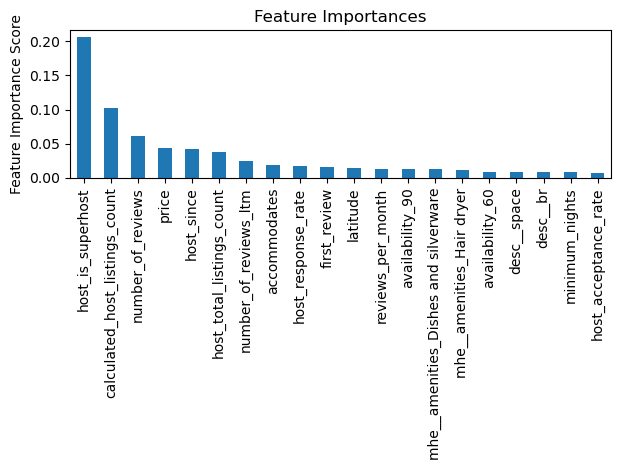

In [122]:
    #Print Feature Importance:
feat_imp = pd.Series(gbm_tuned2.feature_importances_, X_train.columns).sort_values(ascending=False)[:20]
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')
#plt.xticks(rotation=75 )
plt.tight_layout()

#plt.savefig('foo.png', bbox_inches='tight')
plt.show()


In [123]:
gbm_tuned2.score(X_train_ss, y_train)

0.777094017094017

In [124]:
gbm_tuned2.score(X_test_ss, y_test)

0.6913270053973571

In [125]:
add_results(gbm_tuned2, model_comparison_df, X_test_ss, y_test, 'Tuned Gradient Boost', 'n_estimators = 300, default learning rate')

,Model Instance,description,precision,recall,F1
0,DT_w_predictors,First DT Model,0.888509,0.926353,0.907037
1,DT_w_tuning,Second DT Model,0.710857,0.894444,0.792153
2,Tuned Random Forest,first tuned RF,0.724862,0.841026,0.778635
3,Gradient Boosting,out of the box,0.777187,0.728917,0.752279
4,First XGBoost,out of the box,0.730641,0.809117,0.767879
5,Tuned XGBoost,"max_depth=1, n_estimators=296",0.772565,0.738889,0.755352
6,First Logistic Regression,tuned C only,0.602241,0.061254,0.111197
7,SVM Linear Kernel,out of the box,0.691892,0.072934,0.131959
8,SVM RBF Kernel,out of the box,0.653266,1.000000,0.790274
9,First Neural Net,"7 hidden layers, various nodes each, 100 epochs",0.659179,0.509972,0.575054


That did pretty well! Let's try doing another grid search over some other parameters:

In [126]:
parameters = {'max_depth': range(5,16,2),
             'min_samples_split': range(4, 44, 10)}
estimator=GradientBoostingClassifier(n_estimators=300)
clf = GridSearchCV(estimator, parameters, verbose=2, n_jobs=-1)
clf.fit(X_train_ss, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(estimator=GradientBoostingClassifier(n_estimators=300), n_jobs=-1,
             param_grid={'max_depth': range(5, 16, 2),
                         'min_samples_split': range(4, 44, 10)},
             verbose=2)

In [127]:
clf.best_score_

0.7197150997150997

In [128]:
clf.best_params_

{'max_depth': 5, 'min_samples_split': 34}

From that run we found `max_depth` should be 5 and `min_samples_split` = 34.

In [129]:
gbm_tuned3 = GradientBoostingClassifier(learning_rate=0.1, n_estimators=300, 
                                        max_depth=5, min_samples_split=34)

    #Fit the algorithm on the data
gbm_tuned3.fit(X_train_ss, y_train)
        
    #Predict training set:
train_predictions = gbm_tuned3.predict(X_train_ss)
train_predprob = gbm_tuned3.predict_proba(X_train_ss)[:,1]
    
    #Perform cross-validation:

cv_score = cross_val_score(gbm_tuned3, X_train_ss, y_train, cv=5, scoring='roc_auc')
    
    #Print model report:
print("\nModel Report")
print("Accuracy : %.4g" % accuracy_score(y_train, train_predictions))
print("AUC Score (Train): %f" % roc_auc_score(y_train, train_predprob))
    

print("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
        


[CV] END ...................max_depth=5, min_samples_split=4; total time=63.5min
[CV] END ..................max_depth=5, min_samples_split=24; total time=88.0min
[CV] END .................max_depth=5, min_samples_split=34; total time=322.4min
[CV] END .................max_depth=7, min_samples_split=14; total time=310.7min
[CV] END ..................max_depth=7, min_samples_split=34; total time= 5.4min
[CV] END ...................max_depth=9, min_samples_split=4; total time= 6.2min
[CV] END ..................max_depth=9, min_samples_split=24; total time= 6.0min
[CV] END ..................max_depth=9, min_samples_split=34; total time= 5.7min
[CV] END .................max_depth=11, min_samples_split=14; total time=22.1min
[CV] END .................max_depth=11, min_samples_split=34; total time=15.8min
[CV] END ..................max_depth=13, min_samples_split=4; total time=33.2min
[CV] END .................max_depth=13, min_samples_split=24; total time=29.1min
[CV] END .................ma

[CV] END ..................max_depth=5, min_samples_split=14; total time=63.5min
[CV] END ..................max_depth=5, min_samples_split=24; total time=88.0min
[CV] END ..................max_depth=7, min_samples_split=4; total time=507.3min
[CV] END .................max_depth=7, min_samples_split=24; total time=127.2min
[CV] END ..................max_depth=7, min_samples_split=34; total time= 5.3min
[CV] END ..................max_depth=9, min_samples_split=14; total time= 6.2min
[CV] END ..................max_depth=9, min_samples_split=34; total time= 6.1min
[CV] END ..................max_depth=11, min_samples_split=4; total time= 6.3min
[CV] END .................max_depth=11, min_samples_split=24; total time=31.7min
[CV] END .................max_depth=11, min_samples_split=34; total time= 6.3min
[CV] END .................max_depth=13, min_samples_split=14; total time=36.3min
[CV] END .................max_depth=13, min_samples_split=34; total time=25.6min
[CV] END ..................m

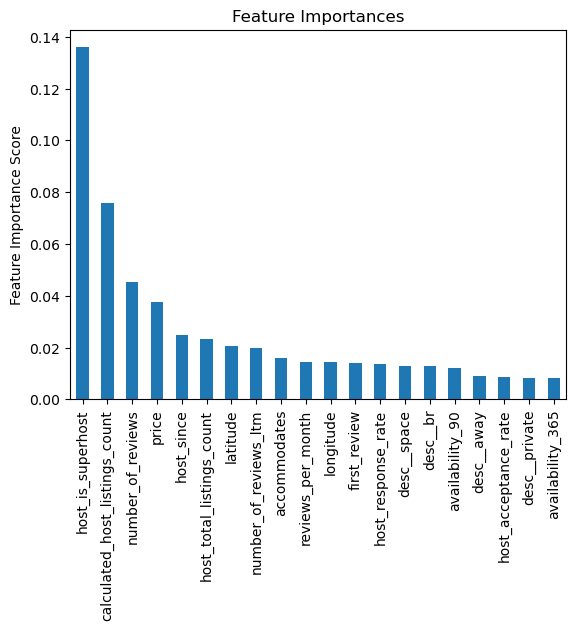

In [130]:
    #Print Feature Importance:
feat_imp = pd.Series(gbm_tuned3.feature_importances_, X_train.columns).sort_values(ascending=False)[:20]
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')
plt.show()

It is interesting to see some new variables made it into our chart. Things like `desc_away` and `desc_space` were not in our previous top features. Let's see how this model scored:

In [131]:
gbm_tuned3.score(X_train_ss, y_train)

0.8548148148148148

In [132]:
gbm_tuned3.score(X_test_ss, y_test)

0.5953843290526708

In [133]:
add_results(gbm_tuned3, model_comparison_df, X_test_ss, y_test, 'Tuned Gradient Boost (2)', 'n_estimators = 300, max_depth=5')

,Model Instance,description,precision,recall,F1
0,DT_w_predictors,First DT Model,0.888509,0.926353,0.907037
1,DT_w_tuning,Second DT Model,0.710857,0.894444,0.792153
2,Tuned Random Forest,first tuned RF,0.724862,0.841026,0.778635
3,Gradient Boosting,out of the box,0.777187,0.728917,0.752279
4,First XGBoost,out of the box,0.730641,0.809117,0.767879
5,Tuned XGBoost,"max_depth=1, n_estimators=296",0.772565,0.738889,0.755352
6,First Logistic Regression,tuned C only,0.602241,0.061254,0.111197
7,SVM Linear Kernel,out of the box,0.691892,0.072934,0.131959
8,SVM RBF Kernel,out of the box,0.653266,1.000000,0.790274
9,First Neural Net,"7 hidden layers, various nodes each, 100 epochs",0.659179,0.509972,0.575054


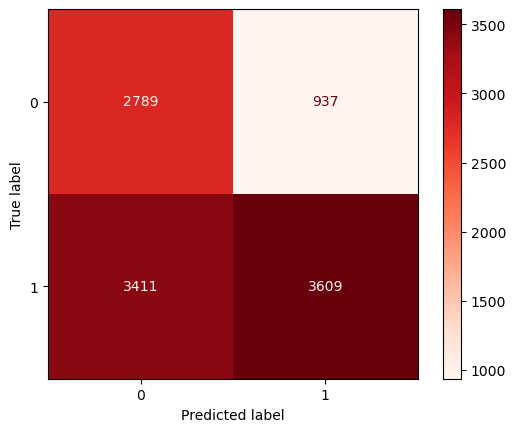

In [134]:
plot_confusion_matrix(gbm_tuned3, X_test_ss, y_test, cmap='Reds');

That did not do as good as our first Gradient Boosting model and seems to be overfitting. One last attempt we can make with our modeling is to downsample the dominant class. We will do that below:

In [135]:
pd.Series(y_test).value_counts()

1    7020
0    3726
dtype: int64

In [136]:
pd.Series(y_train).value_counts()

1    11465
0     6085
dtype: int64

In [137]:
pd.Series(y_val).value_counts()

1    4914
0    2608
dtype: int64

Let's try one last approach. Now we will downsample the majority class so it has an equal distribution to the minority class and we will re-run our gradient boost model:

In [138]:
from sklearn.utils import resample

In [139]:
sample_range = np.arange(X_val.shape[0], X_train.shape[0]+1, 100)

# instantiating our empty lists
sample_size_list = []
train_set_scores = []
val_set_scores = []

# Looping over each value in our sample_range
for sample in sample_range:
    X_downsampled, y_downsampled = resample(X_train_ss, #Creating new sets based on our sample range, with replacement
                                           y_train,
                                           replace=True,
                                           n_samples=sample,
                                           random_state=42)
    

    # Model Fitting and scoring for KNN model
    gbm = GradientBoostingClassifier(learning_rate=0.1, n_estimators=300, 
                                        max_depth=5, min_samples_split=34, random_state=10)
    gbm.fit(X_downsampled, y_downsampled)
    train_score = gbm.score(X_train_ss, y_train)
    valscore = gbm.score(X_val_ss, y_val)
    
    # Calculating the model runtime
    runtime = end - start
    
    #Append values to the respective lists
    sample_size_list.append(sample)
    train_set_scores.append(train_score)
    val_set_scores.append(score)

NameError: name 'end' is not defined

In [ ]:
plt.figure()
plt.plot(sample_size_list, val_set_scores)
plt.title('Validation Set Accuracy Score vs Downsampled y_val Data')
plt.ylabel("accuracy score")
plt.xlabel('Number of Observations')
plt.show()

In [ ]:
best_val = np.argmax(val_set_scores)
sample_size_list[best_val]

So it looks like a sample size of 17,322 yielded the best results:

In [ ]:
X_downsampled, y_downsampled = resample(X_train_ss, #Creating new sets based on our sample range, with replacement
                                           y_train,
                                           replace=True,
                                           n_samples=17322,
                                           random_state=42)
    

# Model Fitting and scoring for gbc model
gbm = GradientBoostingClassifier(learning_rate=0.1, n_estimators=300, 
                                        max_depth=5, min_samples_split=34)
gbm.fit(X_downsampled, y_downsampled)
score = gbm.score(X_test_ss, y_test)

In [ ]:
score

In [ ]:
add_results(gbm, model_comparison_df, X_test_ss, y_test, 'Downsampled Gradient Boost', 'n_estimators = 300, max_depth=5')

In [ ]:
model_comparison_df.to_csv('df.csv')

Let's look at the confusion matrix for this model:

In [ ]:
plot_confusion_matrix(gbm, X_test_ss, y_test, cmap='Reds');

Our "best" model thus far is at index location $11$ in the table above. That is the model we will be using for our pipeline in our model application.

In [ ]:
model_comparison_df.iloc[11]

In [ ]:
gbm_tuned2

With a pipeline, we can combine the steps of scaling our data and running the model:

In [ ]:
from sklearn.pipeline import Pipeline

In [ ]:
estimators = [('normalize', StandardScaler()),
             ('gradboost', GradientBoostingClassifier(min_samples_split=4, n_estimators=300))]

pipe = Pipeline(estimators)

In [ ]:
pipe.fit(X_train, y_train)

In [ ]:
pipe.score(X_test, y_test)

In [ ]:
import joblib

The below line is to save the model to a `.pkl` file. It is commented out so the file does not save to anyone's machine.

In [ ]:
#joblib.dump(pipe, "gradboost.pkl")

## Conclusion

In this notebook we have done the following:
- Tried out various different model types including Decision trees, random forests, Neural Networks, and Gradient Boosting methods
- We ultimately decided on a Gradient Boosting model and attempted to tune it's hyperparameters without much successs. 
- We exported our model to a `.pkl` file so it can be used for further applications.

## Project Conclusion:
- The end of this notebook concludes the Airbnb host score prediction project. Some next steps are listed below:

    1. Trim down/automate the notebooks further
    2. Deploy the model to a web app
    3. Allow for prediction in more cities
    
If you've made it this far, thank you for reading! 